<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Gradient Descent Lab

_Authors: Ben Shaver (DC), h/t Matt Brems (DC)_

### Learning Objectives:
- Review the basics of linear regression
- Implement gradient descent by scratch to fit a simple linear regression model
- Practice basic layered plots in Matplotlib

---


## Introduction and preliminaries

In this lab, we'll examine some (completely made up) data in order to fit a model that predicts a GA grad's salary as a function of their number of years of pre-GA professional experience. First, you'll guess at the relationship between those two variables, and then we'll implement gradient descent from scratch in order to iteratively improve our guess until we end up with a well-fitted model.

(You may find that [this article](https://spin.atomicobject.com/2014/06/24/gradient-descent-linear-regression/) helps you understand gradient descent. Reading through it *may* be a good decision before you complete this lab, though it should not be necessary.)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#### Write a Python function that predicts a student's post-GA income based on their number of years of previous experience:
It should take years of experience, an intercept _b_, and a slope _m_ as arguments. (In simple linear regression, we call the y-intercept $\beta_0$ and the slope $\beta_1$, but we'll use $b$ and $m$ for ease.) It will return the post-GA income.

In [3]:
def determine_income(experience, b, m):
    income = b + m * experience
    return income

Below, we've provided 100 hypothetical graduates with varying years of experience. Run this cell to save this as `years_exp`.

In [4]:
years_exp = pd.read_pickle('data.pickle')['Years of Experience']

In [8]:
years_exp.describe()

count    100.000000
mean       5.792307
std        1.816337
min        0.760510
25%        4.798189
50%        5.746087
75%        6.811904
max        9.704556
Name: Years of Experience, dtype: float64

How much do **you** think a GA grad makes if they have no prior experience? How much do **you** think an additional year of experience adds to the post-GA salary? Using the function you wrote above and the years of experience for 100 hypothetical graduates provided, generate 100 predictions based on your assumptions.

In [9]:
b_guess = 50000  #salary for grad with no prior experience
m_guess = 10000  #additional for each year of experience
preds   = [determine_income(x, b_guess, m_guess) for x in years_exp]

#### Now, load in the rest of the pickled dataframe, and run the following cell to visualize the observed relationship between years of experience and post-GA income:

(For more information on Pandas' `to_pickle` and `read_pickle` methods, refer to the documentation [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_pickle.html). Mmmm pickles.)

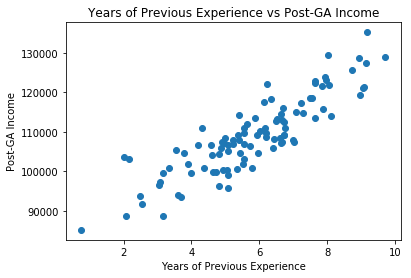

In [10]:
income_data = pd.read_pickle('data.pickle')

plt.scatter(income_data['Years of Experience'], income_data['Post-GA Income'])
plt.title('Years of Previous Experience vs Post-GA Income')
plt.xlabel('Years of Previous Experience')
plt.ylabel('Post-GA Income');

#### Duplicate the scatter plot above, but with *your* predictions plotted as a red line.

How close were you?

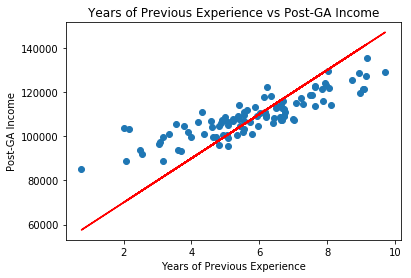

In [11]:
plt.scatter(income_data['Years of Experience'], income_data['Post-GA Income'])
plt.title('Years of Previous Experience vs Post-GA Income')
plt.xlabel('Years of Previous Experience')
plt.ylabel('Post-GA Income')
plt.plot(years_exp, preds, color='r');

#### In the context of linear regression, what does the following function compute? Rename the function appropriately.

In [12]:
def mse(y_true, y_pred):
    n = len(y_true)
    se = [(y_true[i] - y_pred[i])**2 for i in range(n)]
    return(np.sum(se)/n)

#### The function above is just one of many functions we use for a certain purpose. In machine learning, what do we call these type of functions?

In [ ]:
#loss function

## Gradient Descent

We use gradient descent to find the set of parameter values that minimizes some function. Let's say we want to minimize this function:

<img src='img1.png'>

The parameters of a simple linear regression model are $m$ and $b$. In `statsmodels` and `scikit-learn`, when we run `.fit()`, we are estimating the value of these parameters by identifying a best guess. (Equivalently, we find the **best fit line** by finding the values of $m$ and $b$ that minimize the sum of squared errors.)

In *ordinary least squares regression*, we can directly find the values of $m$ and $b$ that minimize SSE by solving $\hat{\beta} = (X^TX)^{-1}X^Ty$. 

However, there are a lot of machine learning techniques that can't be optimized in such a simple way. They rely on **gradient descent** as one method of estimating values of the parameters.

Let's walk through an example together of using gradient descent to estimate parameters of a linear regression model.

**Question:** Trying to use as little mathematical terminology as possible, how would you describe a loss function?

**Answer:** A loss function measures how bad our model is. The higher value, the worse our model is.

**Question:** We plot our loss function for all possible values of our parameters $m$ and $b$. Our goal is to find the values of $m$ and $b$ that {blank} our loss function. 

**What goes in the blank above?**

Given the loss function above, we take the partial derivative of this function with respect to $m$ and $b$. We've done the math for you. Here is the result:
<img src='img2.png'>

#### Write two functions:
- The first function, `partial_derivative_m`, should take as inputs a list of $x$ values, a list of $y$ values, a $b$ value, and an $m$ value. *It should return how much the loss function changes for a one-unit change in $m$.*
- The second function, `partial_derivative_b`, should take as inputs a list of $x$ values, a list of $y$ values, a $b$ value, and an $m$ value. *It should return how much the loss function changes for a one-unit change in $b$.*

In [13]:
def partial_derivative_m(x, y, b, m):
    n = len(x)
    return((2/n) * np.sum([-x[i]*(y[i]-(m*x[i]+b)) for i in range(n)]))


In [14]:
def partial_derivative_b(x, y, b, m):
    n = len(x)
    return((2/n) * np.sum([-(y[i]-(m*x[i]+b)) for i in range(n)]))


#### In your own words, what do these partial derivative functions represent, and how are they relevant in gradient descent?

**Answer:**
- partial_derivative_m return how much the loss function changes for a one-unit change in m. Is important because we want to find the value of m that minimizes our loss function.
- partial_derivative_b return how much our loss function changes for a one-unit change in b. Is important because we want to find the value of b that minimizes our loss function.
- In gradient descent, we're going to start at some point and then "slide" down to the bottom. The partial derivative will be helpful for us to identify the direction in which we should slide.

#### Now that you've answered that question, it's time to actually implement gradient descent! 

You might find this formula helpful:
$$
\beta_1 := \beta_1 - \alpha \frac{\partial L}{\partial \beta_1}
$$

First, write a function called `take_step` that will improve our model fit by taking a single step. It will take five inputs:

- A list of x values
- A list of y values
- A current b value
- A current m value
- A learning rate

It will return two outputs:
- A new b value
- A new m value

*(Hint: Your function should make use of the two functions you just wrote!)*

In [15]:
def take_step(x, y, b, m, learning_rate):
    gradient_b = partial_derivative_b(x, y, b, m)
    gradient_m = partial_derivative_m(x, y, b, m)
    new_b = b - (learning_rate * gradient_b)
    new_m = m - (learning_rate * gradient_m)
    return(new_b, new_m)

#### Now, define a function that will keep on taking steps until the function is minimized.

You will need to decide on a *stopping criterion*. This could be a finite number of iterations you want your gradient descent to run, or it could be some special condition which causes your loop to end. Choose a stopping criterion, and defend your choice. (You may want to try out a few different stopping criteria.)

In [22]:
def gradient_descent(x, y, b, m, learning_rate=.01):
    max_iter = 1000 
    count = 0
    while True:
        count += 1
        if count == max_iter:
            print('Max iterations reached')
            break
        
        b_1, m_1 = take_step(x, y, b, m, learning_rate)
        
        b = b_1
        m = m_1
        
    return(b, m)

#### Run your gradient descent function to move from your first guess to what the true values of _m_ and _b_ are, and plot a line showing the best model that gradient descent found:

Max iterations reached
Final intercept:  76478.1959427
Final slope:  5541.96662545


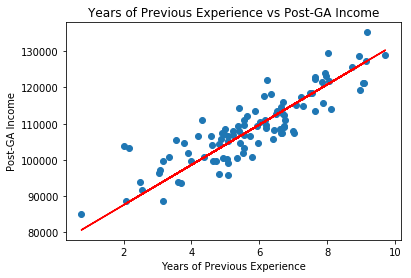

In [23]:
b, m = gradient_descent(x=years_exp, y=income_data['Post-GA Income'], b=b_guess, m=m_guess, learning_rate = .01)
print('Final intercept: ', b)
print('Final slope: ', m)
preds     = [determine_income(x, b=b, m=m) for x in years_exp]
plt.scatter(income_data['Years of Experience'], income_data['Post-GA Income'])
plt.title('Years of Previous Experience vs Post-GA Income')
plt.xlabel('Years of Previous Experience')
plt.ylabel('Post-GA Income')
plt.plot(years_exp, preds, color='r');

#### Import `statsmodels` and fit an OLS model with your data. Compare your results to what you found above.

In [21]:
import statsmodels.api as sm

indep = sm.add_constant(income_data['Years of Experience'])
lm = sm.OLS(preds, indep).fit()
lm.summary()

/Users/claugreco/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.080e+32
Date:                Mon, 26 Mar 2018   Prob (F-statistic):               0.00
Time:                        09:55:14   Log-Likelihood:                 2395.6
No. Observations:                 100   AIC:                            -4787.
Df Residuals:                      98   BIC:                            -4782.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                7.648e+04   3.24e-12   2.36e+16      0.000    7.65e+04    7.65e+04
Years of Experience  5541.9666   5.33e-13   1.04e+16      0.000    5541.967    5541.967
==============================================================================
Omnibus:                        1.463   Durbin-Watson:                   1.093
Prob(Omnibus):                  0.481   Jarque-Bera (JB):               16.693
Skew:                           0.283   Prob(JB):                     0.000237
Kurtosis:                       1.080   Cond. No.                         20.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Visualization Prompt:

Modify the function you've just written so that you save all the intermediate *b* and *m* values. Plot the same scatter plot, but with a line showing the models gradient descent found before convergence. Use a small `alpha` to make your lines semi-transparent, and experiment so your audience can see the route your gradient descent took before it settled on the best model.

To get you started, here is some Python code you might use as a template:

```python
plt.scatter(...                 # Plot the data 
plt.title(...                   # Add a title
plt.xlabel(...                  # Add axis
plt.ylabel(...                  #     labels
plt.plot(...                    # Plot your first guess
for i in range(...)):           # Iterate through for each iteration, optionally using `step` to skip some
    preds = make_preds(...      # Make prediction using your current b and m values
    plt.plot(..., alpha=...     # Plot the intermediate model with a transparent line
plt.plot(...                    # Plot the final best model
```

In [24]:
def gradient_descent(x, y, b, m, learning_rate=.01):
    max_iter = 1000 
    count = 0
    m_list = [m]
    b_list = [b]
    while True:
        count += 1
        if count == max_iter:
            print('Max iterations reached')
            break
        
        b_1, m_1 = take_step(x, y, b, m, learning_rate)
        
        m_list.append(m_1)
        b_list.append(b_1)
        
        b = b_1
        m = m_1
        
    return(b, m, b_list, m_list)

In [25]:
def make_preds(year_exp, b, m):
    return([determine_income(x, b=b, m=m) for x in years_exp])

Max iterations reached


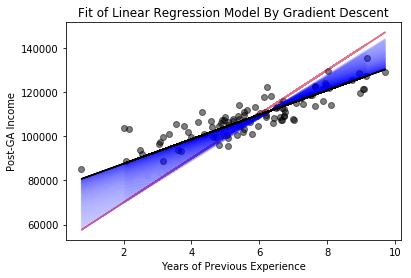

In [28]:
b, m, b_list, m_list = gradient_descent(x=years_exp, y=income_data['Post-GA Income'], b=b_guess, m=m_guess, learning_rate = .01)

plt.scatter(income_data['Years of Experience'], income_data['Post-GA Income'], color='black', alpha=.50)
plt.title('Fit of Linear Regression Model By Gradient Descent')
plt.xlabel('Years of Previous Experience')
plt.ylabel('Post-GA Income')
plt.plot(years_exp, make_preds(years_exp, b_guess, m_guess), color='r', alpha=.5)
iters = len(b_list)
for i in range(0,iters,int(iters/100)):
    plt.plot(years_exp, make_preds(years_exp, b_list[i], m_list[i]), color='b', alpha=.1)

plt.plot(years_exp, make_preds(years_exp, b, m), color='black');

## Bonus Questions:

- Build on your function to implement stochastic gradient descent.
- Wrap the above functions into a class that can implement both types of gradient descent.
- Use the in-class slides to build out functions that can implement gradient descent for **logistic regression**.